In [1]:
import pickle
from warnings import filterwarnings
filterwarnings('ignore')
from IPython.core.display import HTML, display

import numpy as np
import pandas as pd

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

from theano import shared
import theano.tensor as tt
import pymc3 as pm
from tqdm import tqdm

import matplotlib.pyplot as pl
from matplotlib import rcParams
from seaborn import PairGrid, heatmap, kdeplot
import cmocean.cm as cmo
from pymc_utils import PyMCModel
from pymc_utils import subset_significant_feature
from pymc_utils import lasso_regression

In [2]:
% matplotlib inline
rcParams['axes.titlesize'] = 18
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 16
display(HTML("<style>.container{width: 90% !important}</style>"))

In [3]:
df_aphy = pd.read_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_SWF.pkl')
df_aphy_wi = pd.read_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_PolyFeatures_SWF.pkl')

In [4]:
df_aphy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 23 columns):
sin_doy_s         162 non-null float64
cos_doy_s         162 non-null float64
sin_minofday_s    162 non-null float64
cos_minofday_s    162 non-null float64
x_s               162 non-null float64
y_s               162 non-null float64
z_s               162 non-null float64
log10_etopo2_s    162 non-null float64
oisst_s           162 non-null float64
solz_s            162 non-null float64
PC1_s             162 non-null float64
PC2_s             162 non-null float64
PC3_s             162 non-null float64
PC4_s             162 non-null float64
PC5_s             162 non-null float64
PC6_s             162 non-null float64
aphy411           162 non-null float64
aphy443           162 non-null float64
aphy489           162 non-null float64
aphy510           162 non-null float64
aphy555           162 non-null float64
aphy670           162 non-null float64
log10_aphy411     162 non-null float6

In [5]:
df_aphy_wi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Columns: 142 entries, sin_doy_s to aphy670
dtypes: float64(142)
memory usage: 179.8 KB


In [6]:
def PlotHeatMap(df, ax=None,):
    if ax is None:
        _, ax = pl.subplots(figsize=(20, 20))
    dfc = df.corr().iloc[1:, :-1]
    heatmap(dfc, vmin=-1, vmax=1, cmap=cmo.balance_r, annot=True, annot_kws={'fontsize': 13},
            ax=ax, mask=np.triu(np.ones([dfc.shape[1]]*2), k=1))
    ax.set_facecolor('k')
    return ax

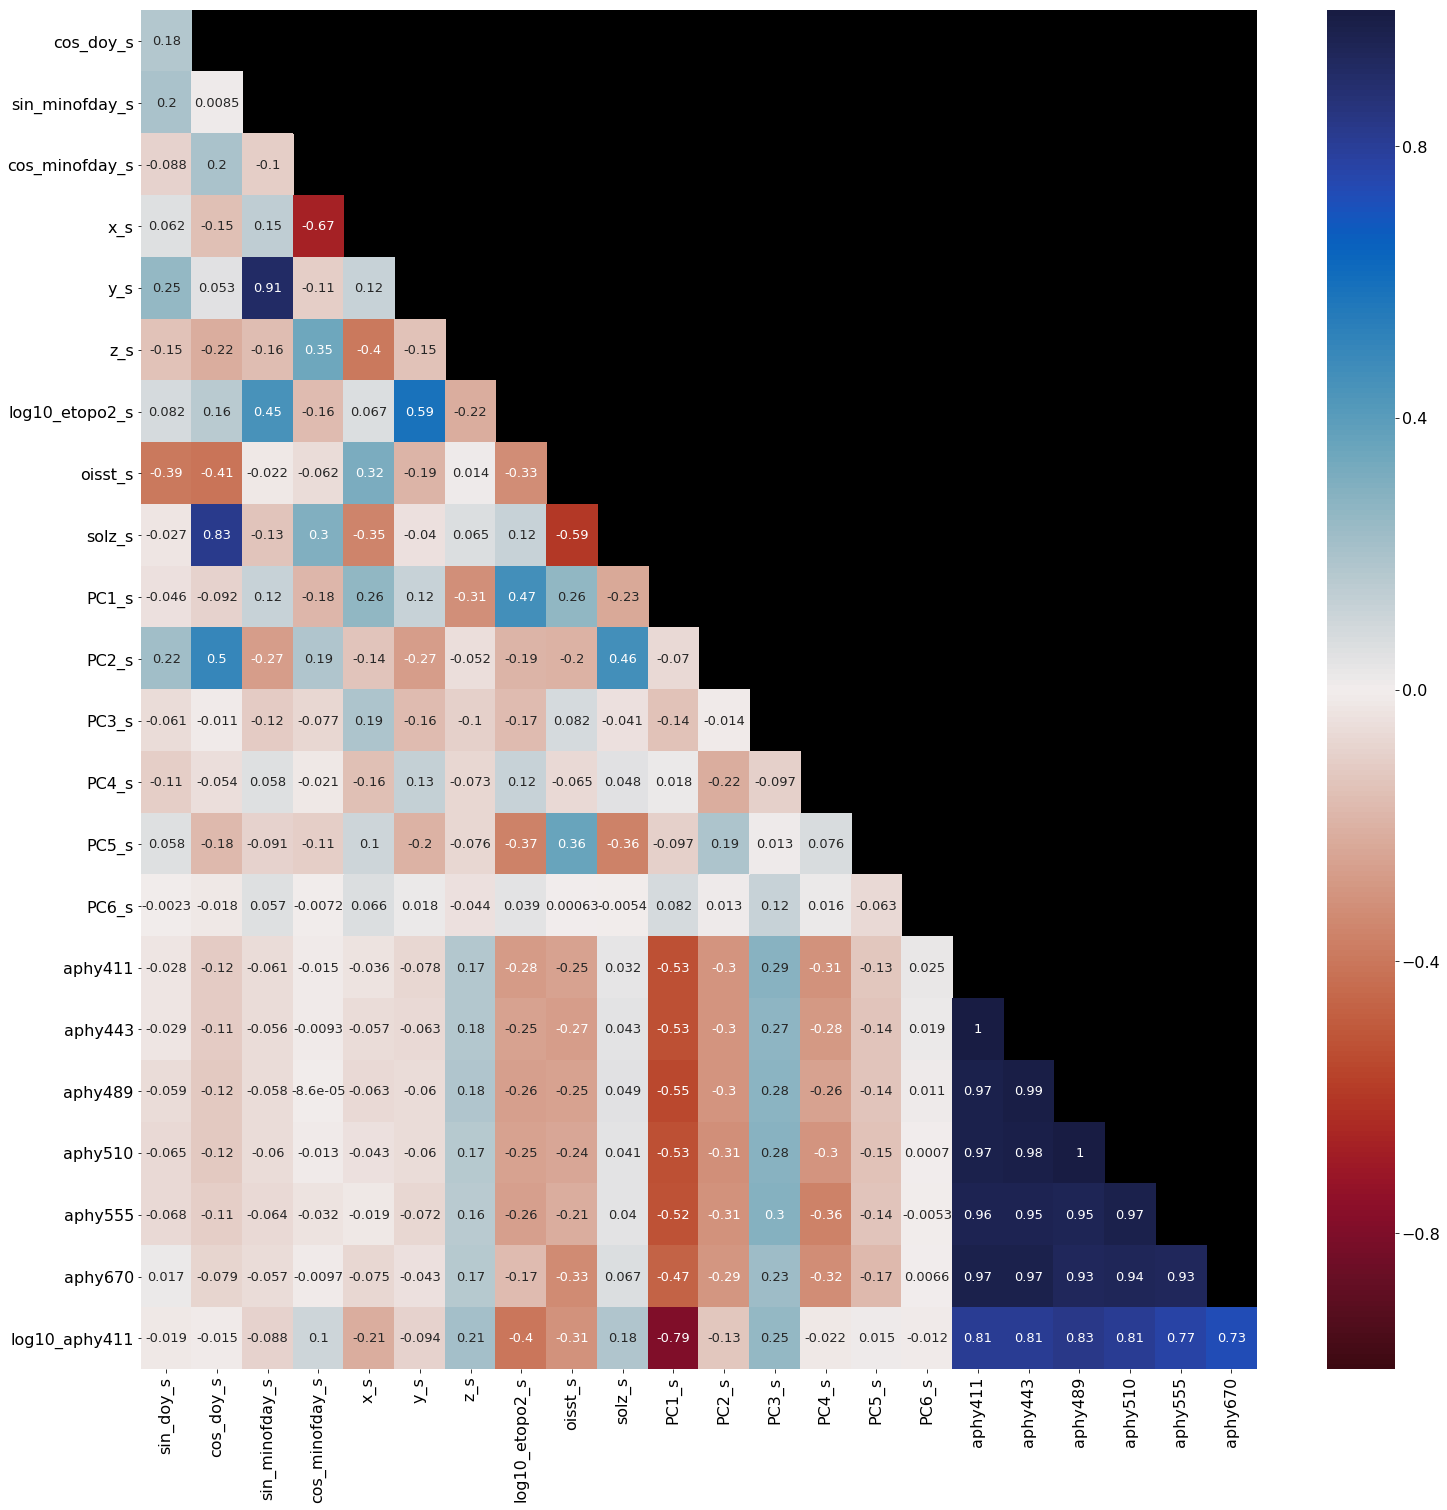

In [7]:
f, ax = pl.subplots(figsize=(25, 25))
ax = PlotHeatMap(df_aphy, ax=ax)
f.savefig('./figJar/aphy_heatmap.png', dpi=150, format='png')

### <u>Modeling</u>

Below the smaller dataset (no interactions features one entry where all PC's are NaNs.
I just drop that row for now. To impute the missing predictors is a bit more complicated than when predicted values are missing.

In [8]:
feat_beg = 'sin_doy_s'
feat_end_ni = 'PC6_s'
feat_end_wi = 'PC5_s PC6_s'
X_s = df_aphy.dropna().loc[:, :feat_end_ni].values
Xps = df_aphy_wi.dropna().loc[:, :feat_end_wi].values

df_aphy['log10_aphy411'] = np.log10(df_aphy.aphy411)
y411 = df_aphy.dropna().aphy411.values
y411_l = df_aphy.dropna().log10_aphy411
y443 = df_aphy.dropna().aphy443.values
y489 = df_aphy.dropna().aphy489.values
y510 = df_aphy.dropna().aphy510.values
y555 = df_aphy.dropna().aphy555.values
y670 = df_aphy.dropna().aphy670.values

In [9]:
df_aphy.describe().T

,count,mean,std,min,25%,50%,75%,max
sin_doy_s,162.0,-7.538551e-17,1.003101,-1.632361,-1.075398,0.291772,0.919767,1.067988
cos_doy_s,162.0,3.807825e-17,1.003101,-1.729100,-0.778317,0.208898,0.685304,1.430161
sin_minofday_s,162.0,1.915477e-16,1.003101,-0.599067,-0.553291,-0.397313,0.053463,4.165531
cos_minofday_s,162.0,-2.193033e-17,1.003101,-1.835295,-0.763772,0.101973,0.788677,2.063419
x_s,162.0,-1.045117e-16,1.003101,-2.523305,0.067800,0.101626,0.322978,2.480050
y_s,162.0,-6.030841e-17,1.003101,-0.570194,-0.540412,-0.281825,-0.081228,4.415726
z_s,162.0,-1.096945e-16,1.003101,-4.151014,0.121210,0.153920,0.480512,1.370943
log10_etopo2_s,162.0,-1.398059e-16,1.003101,-1.962412,-0.768789,-0.369002,0.760279,1.745110
oisst_s,162.0,2.193033e-17,1.003101,-2.990826,-0.781122,0.070849,0.976256,1.396973
solz_s,162.0,-1.072530e-16,1.003101,-1.851402,-0.753258,0.127265,0.760037,1.757741


In [10]:
df_aphy.to_pickle('./pickleJar/OperationalDataSets/df_6_APHY_Standardized_SWF.pkl')

In [11]:
feature_labels=df_aphy.loc[:,:feat_end_ni].columns.tolist()

In [12]:
X_s_train, X_s_test, y_train, y_test = train_test_split(X_s, y411_l, test_size=0.1,
                                                       random_state=42)

In [13]:
X_ps_train, X_ps_test, y_ps_train, y_ps_test = train_test_split(Xps, y411_l,
                                                               test_size=0.1,
                                                               random_state=42)

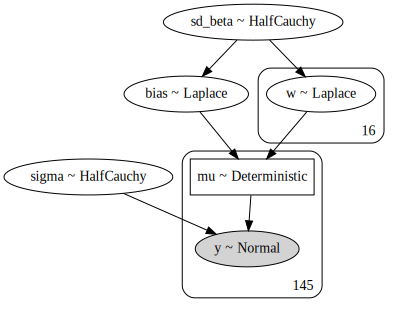

In [14]:
X_shared = shared(X_s_train)
m_lasso_aphy411 = PyMCModel(lasso_regression, X_shared, y_ps_train, model_name='lasso_aphy411')
m_lasso_aphy411.show_model()

In [15]:
m_lasso_aphy411.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, bias, sigma, sd_beta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:06<00:00, 1517.46draws/s]


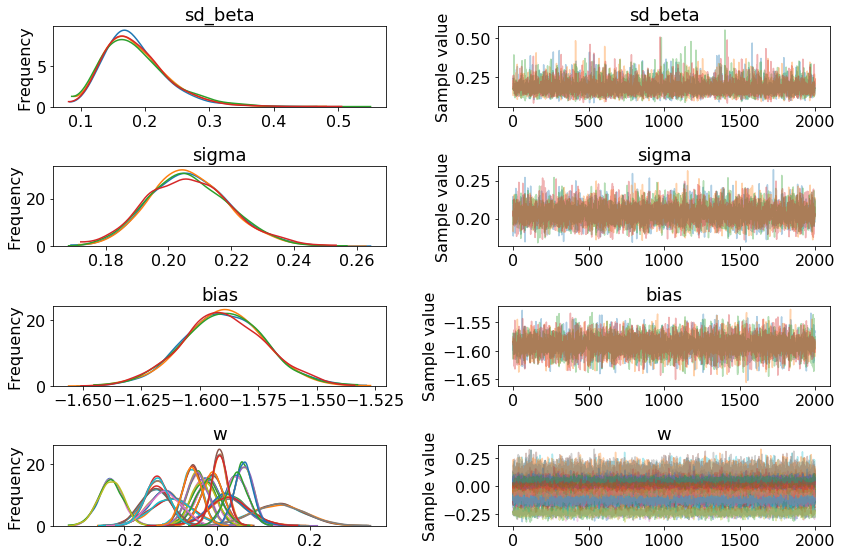

In [16]:
m_lasso_aphy411.evaluate_fit(['sd_beta', 'sigma', 'bias', 'w']);

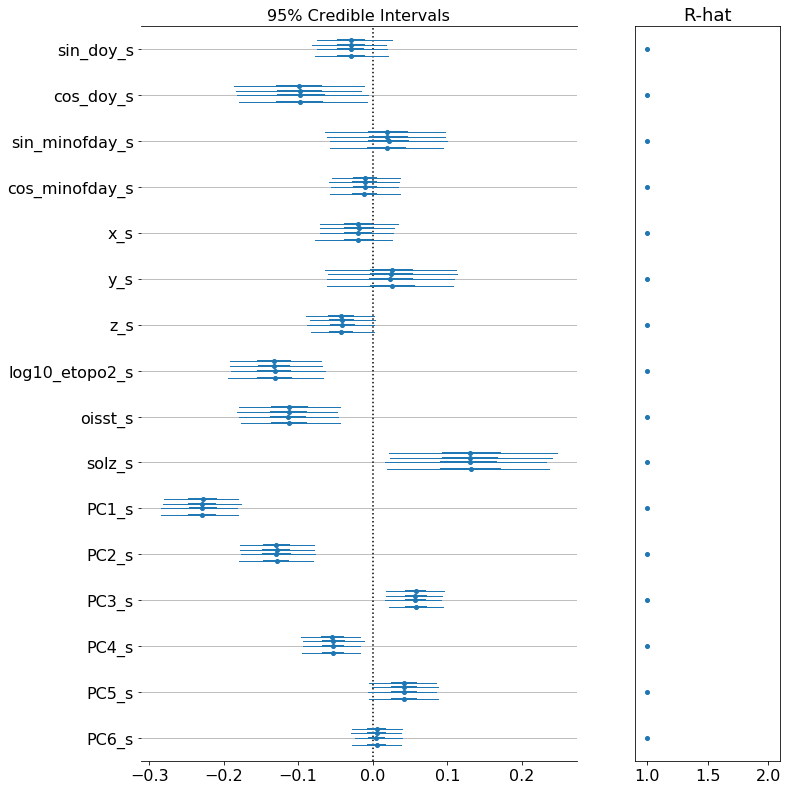

In [17]:
m_lasso_aphy411.show_forest(['w'], feat_labels=feature_labels);
f = pl.gcf()
f.set_figheight(12)
f.set_figwidth(12)
f.savefig('./figJar/APHI411_foresplot.png', dpi=300, format='png')

100%|██████████| 2000/2000 [00:01<00:00, 1690.52it/s]


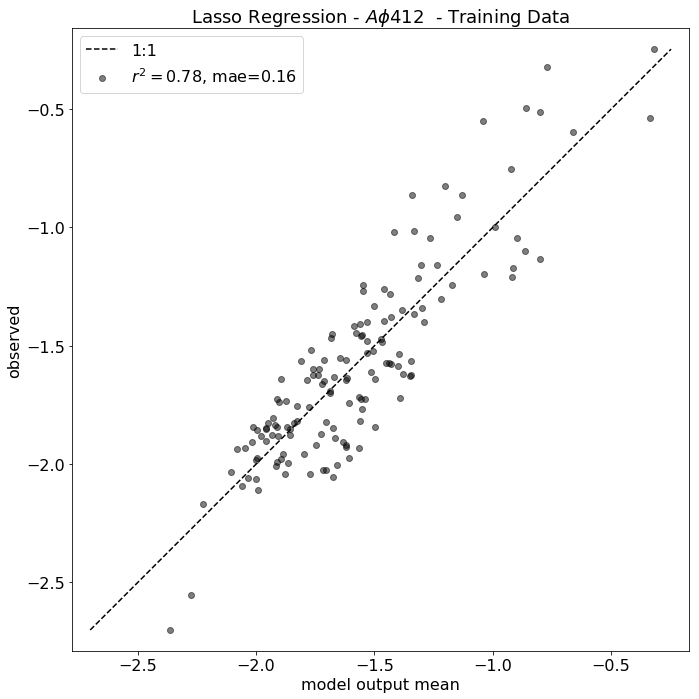

In [18]:
ppc_train_lasso = m_lasso_aphy411.predict(X_shared, likelihood_name='y')
m_lasso_aphy411.plot_model_fits(y_train, ppc_train_lasso, loss_metric='mae',
                               title='Lasso Regression - $A{\phi}{412}$  - Training Data');

100%|██████████| 2000/2000 [00:01<00:00, 1357.62it/s]


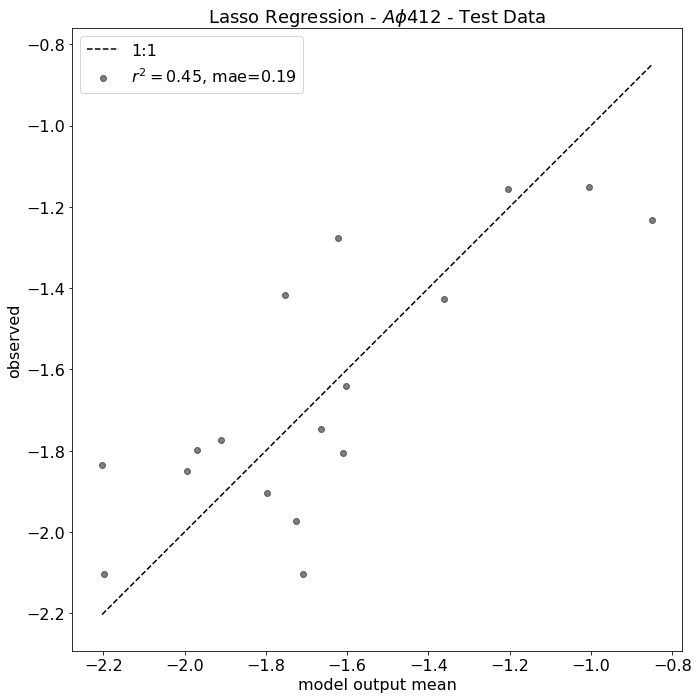

In [19]:
X_shared.set_value(X_s_test)
ppc_test_lasso = m_lasso_aphy411.predict(X_shared, likelihood_name='y')
m_lasso_aphy411.plot_model_fits(y_test, ppc_test_lasso, loss_metric='mae',
                       title='Lasso Regression - $A{\phi}{412}$ - Test Data');

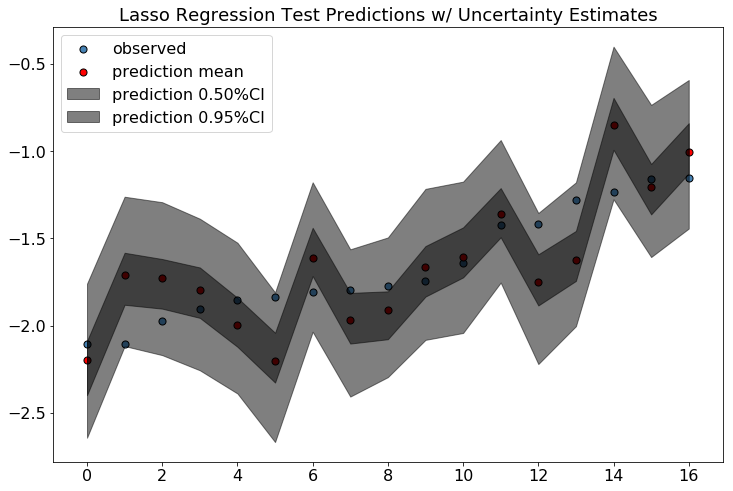

In [20]:
_, ax = pl.subplots(figsize=(12, 8))
ax = m_lasso_aphy411.plot_model_ppc_stats(ppc_test_lasso, y_test, ax=ax)
ax.set_title('Lasso Regression Test Predictions w/ Uncertainty Estimates');

Re-Train Model with all the data and display Posterior Predictive Checks

In [21]:
X_shared = shared(X_s)
m_lasso_aphy411 = PyMCModel(lasso_regression, X_shared, y411_l, model_name='lasso_aphy411')
m_lasso_aphy411.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, bias, sigma, sd_beta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:06<00:00, 1502.80draws/s]


100%|██████████| 2000/2000 [00:01<00:00, 1651.71it/s]


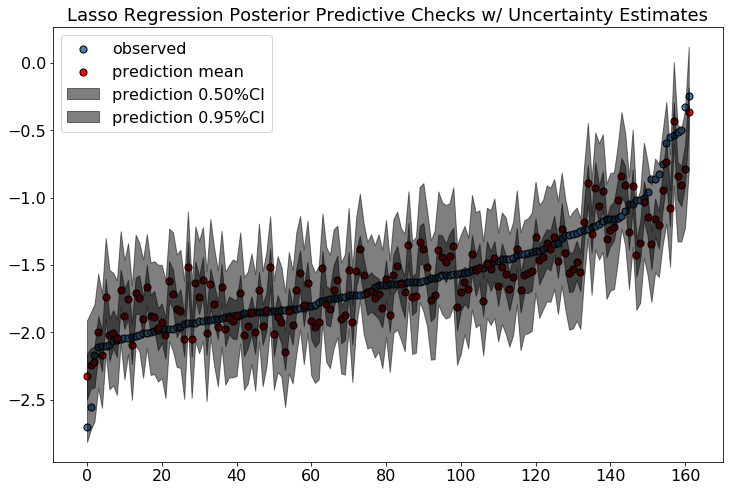

In [22]:
ppc_lasso = m_lasso_aphy411.predict(X_shared, likelihood_name='y')
_, ax = pl.subplots(figsize=(12, 8))
ax = m_lasso_aphy411.plot_model_ppc_stats(ppc_lasso, y411_l, ax=ax)
ax.set_title('Lasso Regression Posterior Predictive Checks w/ Uncertainty Estimates');

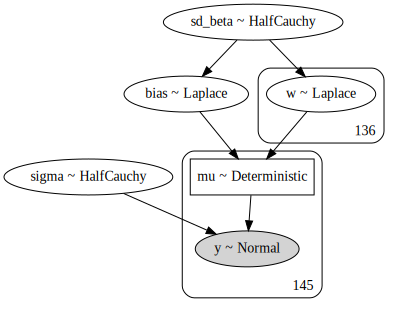

In [23]:
X_ps_shared = shared(X_ps_train)
m_lasso_aphy411_wi = PyMCModel(lasso_regression, X_ps_shared, y_ps_train,
                               model_name='lasso_aphy411_with_interactions')
m_lasso_aphy411_wi.show_model()

In [24]:
m_lasso_aphy411_wi.fit_ADVI()

Average Loss = 124.13: 100%|██████████| 100000/100000 [00:46<00:00, 2145.48it/s]
Finished [100%]: Average Loss = 124.11


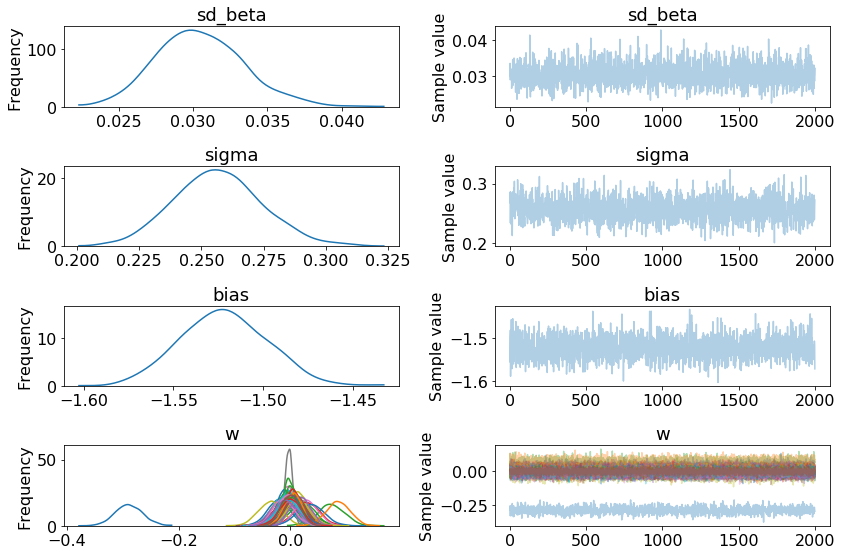

In [26]:
m_lasso_aphy411_wi.evaluate_fit(['sd_beta', 'sigma', 'bias', 'w']);

100%|██████████| 2000/2000 [00:01<00:00, 1621.73it/s]


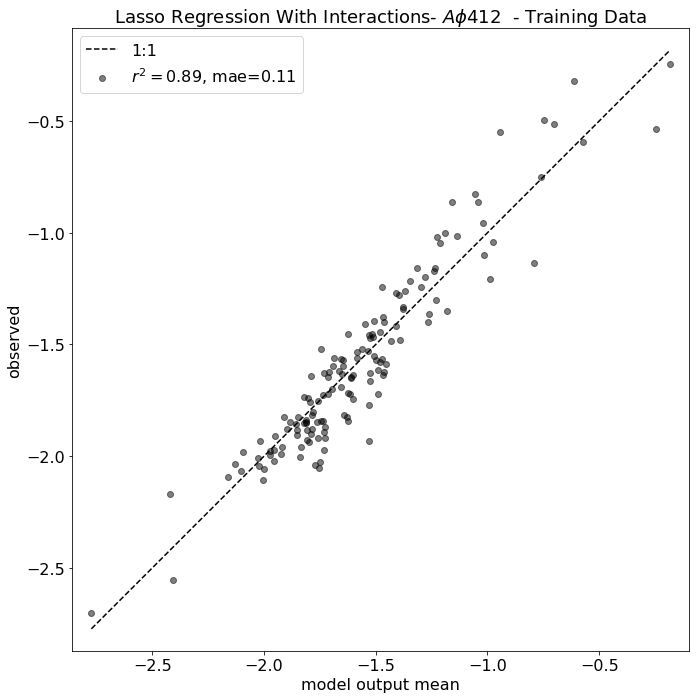

In [27]:
ppc_train_lasso_wi = m_lasso_aphy411_wi.predict(X_ps_shared, likelihood_name='y')
m_lasso_aphy411_wi.plot_model_fits(y_ps_train, ppc_train_lasso_wi, loss_metric='mae',
                               title='Lasso Regression With Interactions- $A{\phi}{412}$  - Training Data');

100%|██████████| 2000/2000 [00:01<00:00, 1317.66it/s]


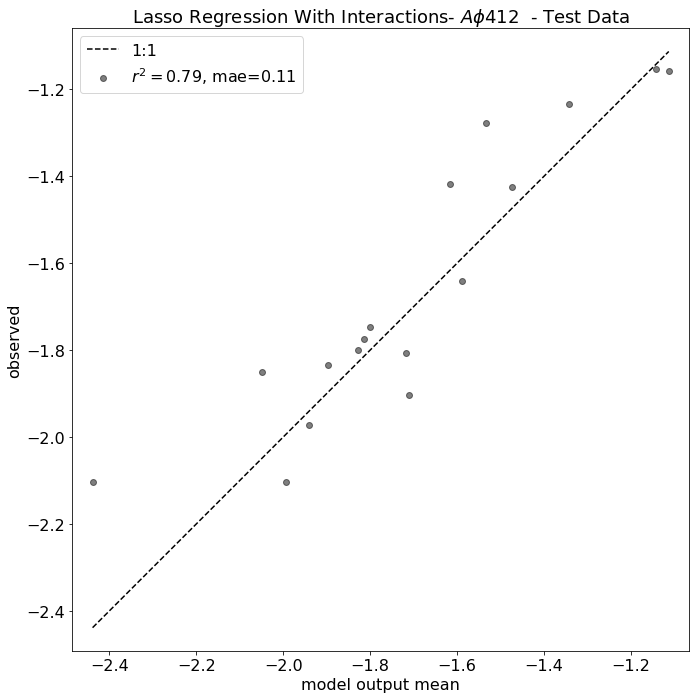

In [28]:
X_ps_shared.set_value(X_ps_test)
ppc_test_lasso_wi = m_lasso_aphy411_wi.predict(X_ps_shared, likelihood_name='y')
m_lasso_aphy411_wi.plot_model_fits(y_ps_test, ppc_test_lasso_wi, loss_metric='mae',
                               title='Lasso Regression With Interactions- $A{\phi}{412}$  - Test Data');

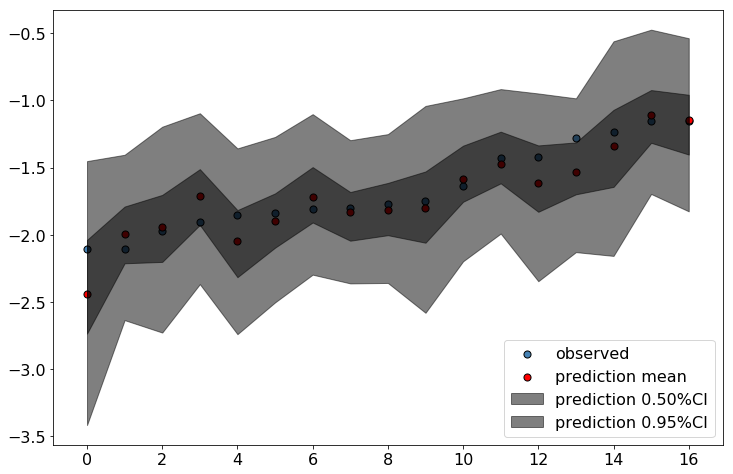

In [29]:
_, ax=pl.subplots(figsize=(12, 8))
ax = m_lasso_aphy411_wi.plot_model_ppc_stats(ppc_test_lasso_wi, y_ps_test, ax=ax)
ax.legend(loc=4);

Re-train Model with Entire DataSet

In [30]:
X_ps_shared = shared(Xps)
m_lasso_aphy411_wi = PyMCModel(lasso_regression, X_ps_shared, y411_l,
                               model_name='lasso_aphy411_with_interactions')
m_lasso_aphy411_wi.fit_ADVI()

Average Loss = 119.49: 100%|██████████| 100000/100000 [00:45<00:00, 2175.23it/s]
Finished [100%]: Average Loss = 119.46


100%|██████████| 2000/2000 [00:01<00:00, 1638.76it/s]


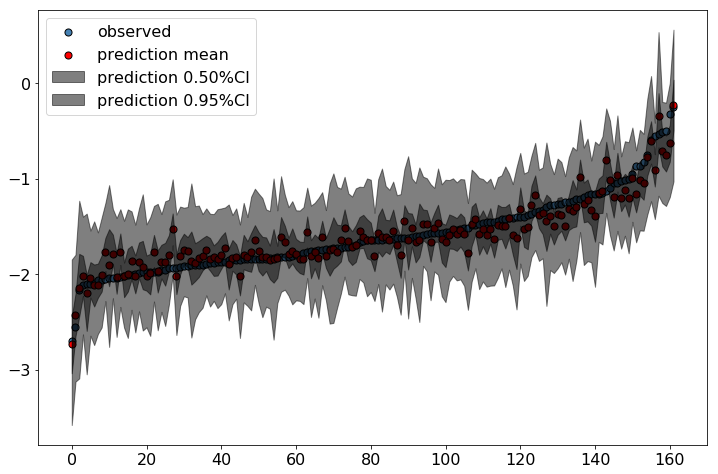

In [31]:
_, ax=pl.subplots(figsize=(12, 8))
ppc_wi = m_lasso_aphy411_wi.predict(X_ps_shared)
ax = m_lasso_aphy411_wi.plot_model_ppc_stats(ppc_wi, y411_l, ax=ax)

In [32]:
feat_lbsl = df_aphy_wi.loc[:, :feat_end_wi].columns.tolist()
lasso_inter_sub_feats = subset_significant_feature(m_lasso_aphy411_wi.trace_, 
                                                    feat_lbsl, feat_beg, alpha=0.1)

In [33]:
Xps_sub_shared = shared(df_aphy_wi.loc[:, lasso_inter_sub_feats].values)
mp_lasso_sub = PyMCModel(lasso_regression, Xps_sub_shared, y411_l, 
                            model_name='lasso_aphy411_w_sub_inter.')

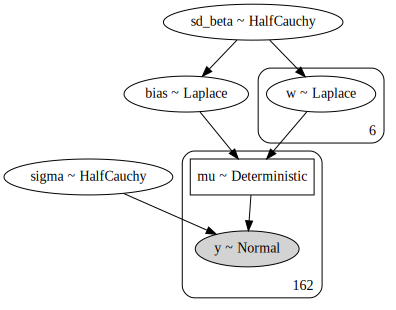

In [34]:
mp_lasso_sub.show_model()

In [35]:
mp_lasso_sub.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, bias, sigma, sd_beta]
Sampling 4 chains: 100%|██████████| 10000/10000 [00:04<00:00, 2480.98draws/s]


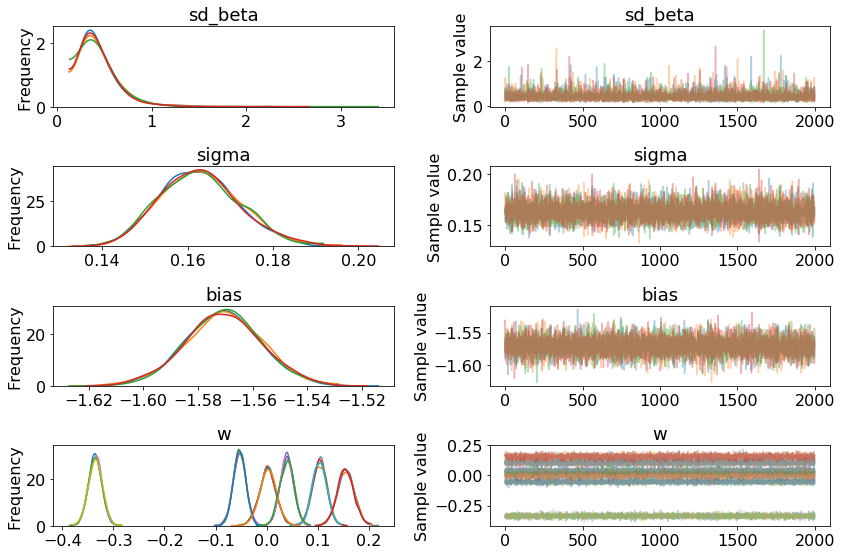

In [36]:
mp_lasso_sub.evaluate_fit(['sd_beta', 'sigma', 'bias', 'w']);

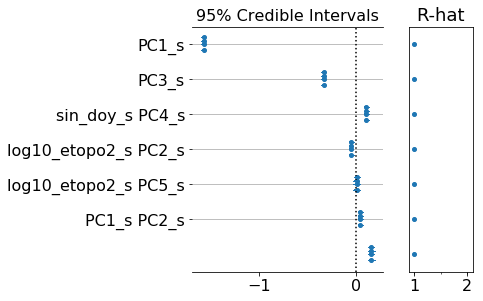

In [37]:
mp_lasso_sub.show_forest(['bias', 'w'], lasso_inter_sub_feats);

100%|██████████| 2000/2000 [00:01<00:00, 1717.10it/s]


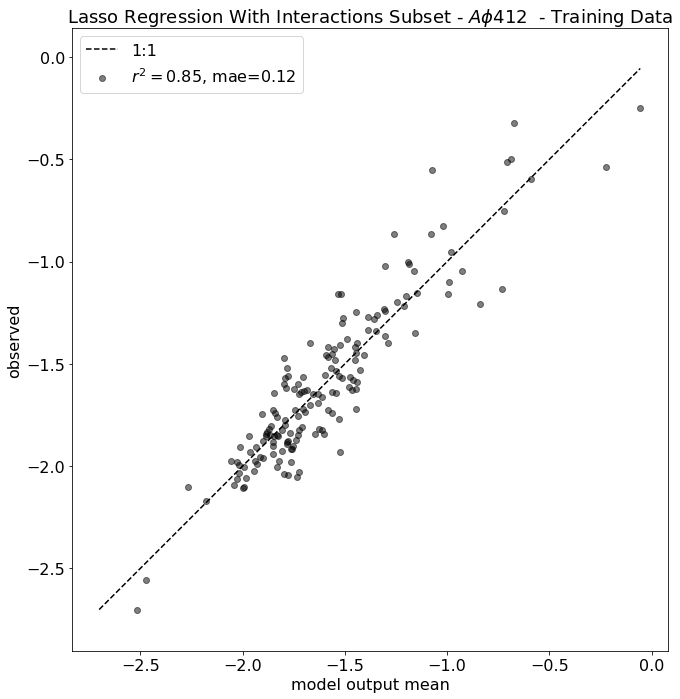

In [43]:
ppc_lasso_wi_sub = mp_lasso_sub.predict(Xps_sub_shared, likelihood_name='y')
mp_lasso_sub.plot_model_fits(y411_l, ppc_lasso_wi_sub, loss_metric='mae',
                               title='Lasso Regression With Interactions Subset - $A{\phi}{412}$  - Training Data');

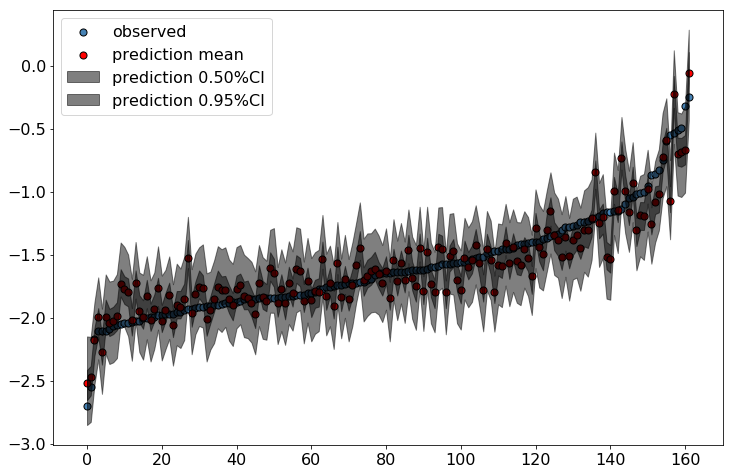

In [44]:
_, ax = pl.subplots(figsize=(12, 8))
ax = mp_lasso_sub.plot_model_ppc_stats(ppc_lasso_wi_sub, y411_l, ax=ax)